# EDA for online_retail dataset
#### This notebook provides a high-level overview of the dataset and provides descriptive values and figures about product popularity, etc. It also shifts it to Double-Entry form at the end to make our balance sheet production easier.

#### online_retail was originally an .xlsx file detailing retail invoices from our company. Using the commented code below, this file was converted to a .csv for ease of use. Additional columns 'Month', 'PurchaseTotal', and 'Cancelled' were appended for readability. All transactions were assumed to be done by credit instead of cash.

#### To reconcile the different datasets, timestamps have been shifted up by 11 years to match the Financial/Managerial Accounting datasets

#### TODO:
<ul>
    <li>nicer colors for graphs</li>
</ul>

### Import, setup, and load

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import colormaps

In [161]:
online_schema = {
    'InvoiceNo': 'string',
    'StockCode': 'string',
    'Quantity': 'int64',
    'UnitPrice' : 'float64',
    'CustomerID' : 'string',
    'Country' : 'string'
}

schema_de = {
    'InvoiceNo': 'string',
    'InvoiceDate': 'datetime64',
    'Type': 'string',
    'Account': 'string',
    'Amount': 'float64'
}

UK = 'United Kingdom'

In [162]:
online = pd.read_csv('data/online_retail.csv', parse_dates=True, dtype=online_schema)
# online = online.sample(100000)
online['InvoiceDate'] = pd.to_datetime(pd.to_datetime(online['InvoiceDate']).dt.date)

### Specifying some handy table projections

In [163]:
online = online.loc[online['InvoiceDate'].dt.year == 2011]
online['PurchaseTotal'] = online['Quantity']*online['UnitPrice']
online['Month'] = online['InvoiceDate'].dt.month
online['InvoiceDate'] = online['InvoiceDate'] + pd.to_timedelta(52*11, unit='W') # Year unit deprecated????? why?????
condition = online['InvoiceNo'].str.contains('C')
online['Cancelled'] = np.where(condition, 1, 0)
online_noCancels = online.loc[online['Cancelled'] == 0]
online_noReturns = online.loc[((online['Quantity'] < 0) & (online['Cancelled'] == 1)) | (online['Quantity'] > 0)]
online_noReturns_noCancels = online.loc[(online['Quantity'] > 0) & (online['Cancelled'] == 0)]
online_noReturns_noCancels_noUK = online_noReturns_noCancels.loc[online_noReturns_noCancels['Country'] != UK]

### Correlation between quantity purchased vs price per unit

In [164]:
stats.pearsonr(online_noReturns_noCancels['Quantity'],online_noReturns_noCancels['UnitPrice']).pvalue

0.020328035156678605

### Correlation between quantity purchased vs price per unit (no UK)

In [165]:
stats.pearsonr(online_noReturns_noCancels_noUK['Quantity'],online_noReturns_noCancels_noUK['UnitPrice']).pvalue

1.4202179486092746e-07

### Is Unit Price a factor in cancellation rates?

In [180]:
prices_cancelled = online_noReturns[online_noReturns['Cancelled'] == 1]['UnitPrice']
prices_fulfilled = online_noReturns[online_noReturns['Cancelled'] == 0]['UnitPrice']
stats.ttest_ind(prices_cancelled, prices_fulfilled, equal_var=False).pvalue

1.7880549128169907e-09

### Highest mean quantity per purchase - the item bought in highest quantities (on average) at a time

In [167]:
oNR_MQP = online_noReturns_noCancels[['StockCode','Description','Quantity']]
mqpp = oNR_MQP.groupby(['StockCode','Description']).mean(numeric_only=True)
oNR_MQP.loc[oNR_MQP['Quantity'] == mqpp['Quantity'].max()]

StockCode                  Description  Quantity
540421     23843  PAPER CRAFT , LITTLE BIRDIE     80995

### Lowest mean quantity per purchase - the item bought in lowest quantities (on average) at a time

In [168]:
oNR_MQP.loc[oNR_MQP['Quantity'] == mqpp['Quantity'].min()].set_index('StockCode')

Description  Quantity
StockCode                                            
22846            BREAD BIN DINER STYLE RED          1
22847           BREAD BIN DINER STYLE IVORY         1
22699      ROSES REGENCY TEACUP AND SAUCER          1
22780        LIGHT GARLAND BUTTERFILES PINK         1
22779            WOODEN OWLS LIGHT GARLAND          1
...                                     ...       ...
22721         SET OF 3 CAKE TINS SKETCHBOOK         1
21351              CINAMMON & ORANGE WREATH         1
22698        PINK REGENCY TEACUP AND SAUCER         1
22567               20 DOLLY PEGS RETROSPOT         1
37500           TEA TIME TEAPOT IN GIFT BOX         1

[133457 rows x 2 columns]

### Most popular items in each country
#### (Many of the top items are postage (POST), detailless manual entries (M), or shipping (C2). These are excluded from aggregation)

In [169]:
oNRNC = online_noReturns_noCancels # shorthand alias
oNRNC = oNRNC.loc[(oNRNC['StockCode'] != 'POST') & (oNRNC['StockCode'] != 'M') & (oNRNC['StockCode'] != 'C2')]
oNRNC = oNRNC[['Country','StockCode','Description','Quantity']]
oNRNC.groupby(['Country','StockCode','Description']).sum().reset_index()
maxIndices = oNRNC.groupby('Country')['Quantity'].idxmax()
oNRNC[['Country','StockCode','Description','Quantity']].loc[maxIndices].sort_values('Quantity', ascending=False).reset_index().drop('index', axis=1)

Country StockCode                          Description  \
0         United Kingdom     23843          PAPER CRAFT , LITTLE BIRDIE   
1            Netherlands     23084                   RABBIT NIGHT LIGHT   
2                  Japan     23084                   RABBIT NIGHT LIGHT   
3              Australia     22492              MINI PAINT SET VINTAGE    
4                   EIRE     84212        ASSORTED FLOWER COLOUR "LEIS"   
5                 France     23084                   RABBIT NIGHT LIGHT   
6                 Sweden     20975  12 PENCILS SMALL TUBE RED RETROSPOT   
7                Germany     15036            ASSORTED COLOURS SILK FAN   
8                 Canada     37370           RETRO COFFEE MUGS ASSORTED   
9        Channel Islands     21785                         RAIN PONCHO    
10                 Spain    84997D    PINK 3 PIECE POLKADOT CUTLERY SET   
11                Cyprus     22335       HEART DECORATION PAINTED ZINC    
12           Switzerland     84568      GIRLS ALPHABET IRON ON PATCHES    
13             Singapore     22339         CHRISTMAS TREE PAINTED ZINC    
14               Austria     21918     SET 12 KIDS COLOUR  CHALK STICKS   
15               Belgium    84536B         FAIRY CAKES NOTEBOOK A7 SIZE   
16               Denmark     23295     SET OF 12 MINI LOAF BAKING CASES   
17               Iceland     23076           ICE CREAM SUNDAE LIP GLOSS   
18                Norway     16008  SMALL FOLDING SCISSOR(POINTED EDGE)   
19                 Italy     23445                    ICE CREAM BUBBLES   
20               Finland     21980    PACK OF 12 RED RETROSPOT TISSUES    
21             Hong Kong     84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS   
22              Portugal     84992       72 SWEETHEART FAIRY CAKE CASES   
23                Israel     20719               WOODLAND CHARLOTTE BAG   
24               Bahrain     23076           ICE CREAM SUNDAE LIP GLOSS   
25                Poland     21232       STRAWBERRY CERAMIC TRINKET BOX   
26        Czech Republic     22579   WOODEN TREE CHRISTMAS SCANDINAVIAN   
27                   USA     23366       SET 12 COLOURING PENCILS DOILY   
28  United Arab Emirates     85215       ASSORTED CHEESE FRIDGE MAGNETS   
29                 Malta     22065       CHRISTMAS PUDDING TRINKET POT    
30                Greece     21616      4 PEAR BOTANICAL DINNER CANDLES   
31           Unspecified    47021G   SET/6 BEAD COASTERS GAUZE BAG GOLD   
32               Lebanon     84929   ASSTD FRUIT+FLOWERS FRIDGE MAGNETS   
33    European Community     23307  SET OF 60 PANTRY DESIGN CAKE CASES    
34                Brazil     22699     ROSES REGENCY TEACUP AND SAUCER    
35                   RSA     22620          4 TRADITIONAL SPINNING TOPS   
36          Saudi Arabia     22915        ASSORTED BOTTLE TOP  MAGNETS    

    Quantity  
0      80995  
1       2400  
2       2040  
3       1152  
4        960  
5        912  
6        768  
7        600  
8        504  
9        407  
10       360  
11       288  
12       288  
13       288  
14       288  
15       272  
16       256  
17       240  
18       240  
19       200  
20       144  
21       144  
22       120  
23       100  
24        96  
25        72  
26        72  
27        72  
28        72  
29        48  
30        48  
31        48  
32        24  
33        24  
34        24  
35        12  
36        12

### Did some countries cancel more than others?

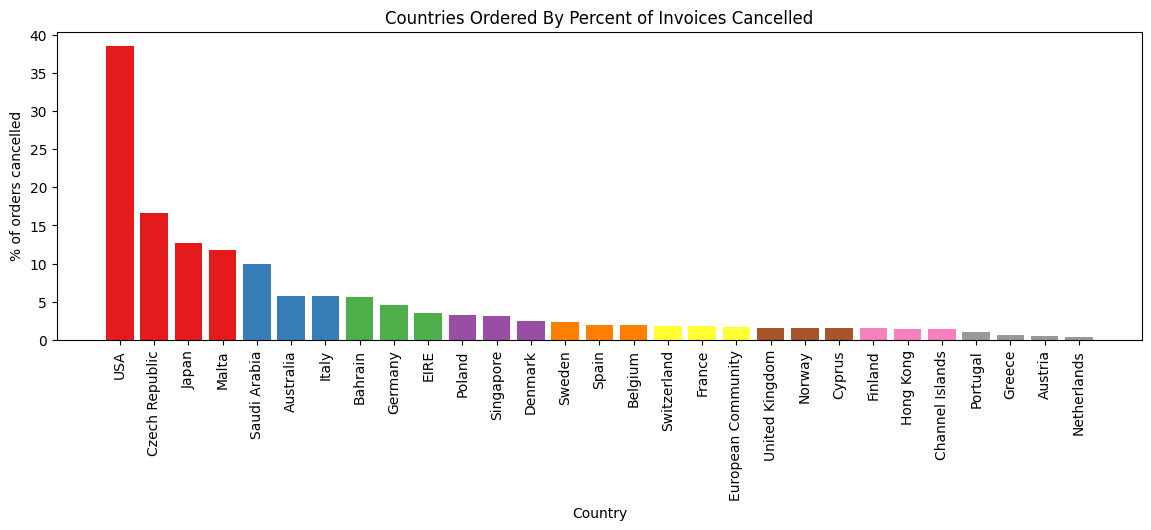

In [170]:
perCountry_All = online_noReturns.groupby('Country').agg(Count=('InvoiceNo', 'count')).reset_index()
perCountry_Cancelled = online_noReturns.loc[online_noReturns['Cancelled'] == 1].groupby(['Country', 'Cancelled']).agg(Count=('InvoiceNo', 'count')).reset_index()

joined = perCountry_All.merge(perCountry_Cancelled[['Country','Count']], on='Country', suffixes=('_All','_Cancelled'))
joined['Ratio'] = 100*joined['Count_Cancelled']/joined['Count_All']
joined = joined.sort_values('Ratio', ascending=False)
plt.figure(figsize=(14,4))
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('% of orders cancelled')
color_range = np.linspace(0,1,len(joined))
plt.title('Countries Ordered By Percent of Invoices Cancelled')
plt.bar(joined['Country'],joined['Ratio'], color=plt.cm.Set1(color_range))
plt.show()

### Did some countries return more than others?

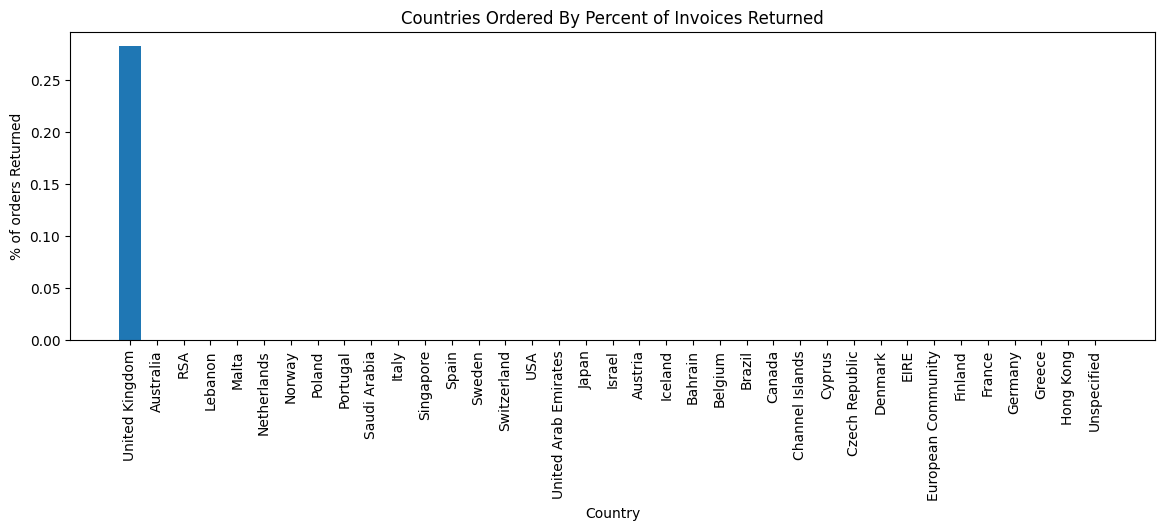

In [171]:
perCountry_All = online_noCancels.groupby('Country').agg(Count=('InvoiceNo', 'count')).reset_index()
perCountry_Returned = online_noCancels.loc[online['Quantity'] < 0].groupby(['Country']).agg(Count=('InvoiceNo', 'count')).reset_index()

perCountry_Returned
joined = perCountry_All.merge(perCountry_Returned[['Country','Count']], on='Country', how='left', suffixes=('_All','_Returned')).fillna(0) 
joined['Ratio'] = 100*joined['Count_Returned']/joined['Count_All']
joined = joined.sort_values('Ratio', ascending=False)
plt.figure(figsize=(14,4))
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('% of orders Returned')
plt.title('Countries Ordered By Percent of Invoices Returned')
plt.bar(joined['Country'],joined['Ratio'])
plt.show()

#### I am willing to bet that returns are only accepted domestically.

### Trend: Net income over time - aggregated by month - 2022 (the only complete year)

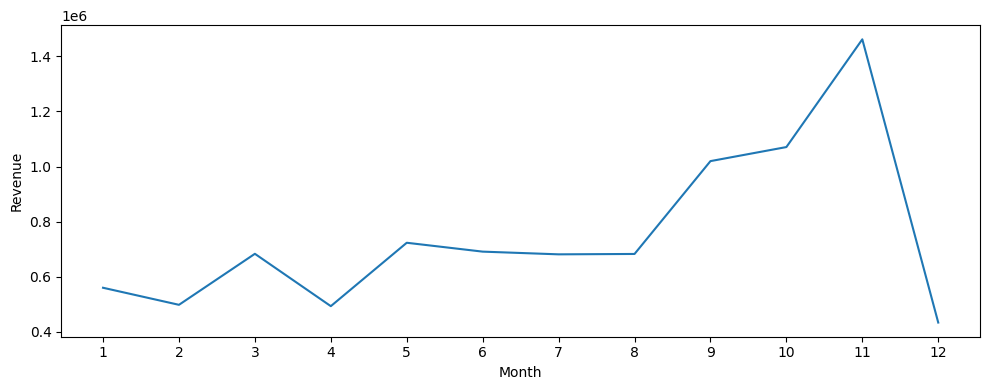

In [172]:
onlineAgg_perMonth = online[['InvoiceDate','Quantity','PurchaseTotal','Month']] \
    .groupby(['Month']).sum(numeric_only=True).reset_index()
plt.figure(figsize=(10,4))
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.plot(onlineAgg_perMonth['Month'],onlineAgg_perMonth['PurchaseTotal'])
plt.tight_layout()

### Cleaning up rows with blank info and transforming to Double Entry form

In [173]:
online_cleaned = online.loc[(online['Description'].notna())&(online['Quantity'].notna())&(online['UnitPrice'].notna()) \
&(online['InvoiceDate'].dt.year == 2022)]
online_cleaned = online_cleaned.groupby(['InvoiceNo','InvoiceDate']).sum(numeric_only=True).reset_index()

In [174]:
double_entry = pd.DataFrame(columns=schema_de.keys()).astype(schema_de)

def create_double_entry(row):
    debit_row = {
        'InvoiceNo': row['InvoiceNo'],
        'InvoiceDate': row['InvoiceDate'],
        'Type': 'Debit',
        'Account': 'Accounts Receivable',
        'Amount': row['PurchaseTotal']
    }

    credit_row = {
        'InvoiceNo': row['InvoiceNo'],
        'InvoiceDate': row['InvoiceDate'],
        'Type': 'Credit',
        'Account': 'Revenue',
        'Amount': row['PurchaseTotal']
    }
    return pd.DataFrame([debit_row, credit_row], columns=schema_de.keys())

double_entry = pd.concat(online_cleaned.apply(create_double_entry, axis=1).to_list(), ignore_index=True)